<b> Cervival Cancer risk classification

- <b> Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import RandomOverSampler

- <b> Data Cleaning

In [2]:
df = pd.read_csv("cervical.csv")
df

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,0,15,0,0,0.0,0.0,0,0.00,0,...,0,0,0,0,0,0,0,0,0,0
1,15,0,14,0,0,0.0,0.0,0,0.00,0,...,0,0,0,0,0,0,0,0,0,0
2,34,0,0,0,0,0.0,0.0,0,0.00,0,...,0,0,0,0,0,0,0,0,0,0
3,52,0,16,0,0,37.0,37.0,0,0.00,0,...,0,0,0,0,0,0,0,0,0,0
4,46,0,21,0,0,0.0,0.0,0,15.00,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,34,0,18,0,0,0.0,0.0,0,0.00,0,...,0,0,0,0,0,0,0,0,0,0
854,32,0,19,0,0,0.0,0.0,0,0.00,0,...,0,0,0,0,0,0,0,0,0,0
855,25,0,17,0,0,0.0,0.0,0,0.08,0,...,0,0,0,0,0,0,0,0,0,0
856,33,0,24,0,0,0.0,0.0,0,0.08,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# remove all stds column (too much na value)
df1 = df.iloc[:, :12]
df2 = df.iloc[:, -4:]

df = pd.concat([df1, df2], axis="columns")
df = df.replace([np.inf, -np.inf], np.nan)
df.fillna(0, inplace=True)

In [4]:
# convert df to int
df.fillna(0)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.astype(int)

In [5]:
# Features selection (10 best correlation)
corr = df.corr()['Biopsy'].abs().sort_values(ascending=False)

k = 10
selected_features = corr[1:k+1].index.tolist()

new_df = df[selected_features + ['Biopsy']]

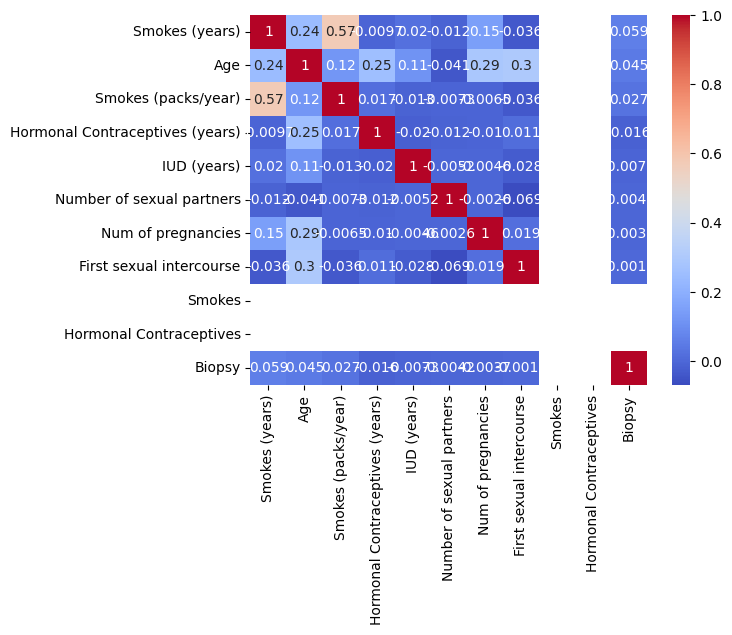

In [6]:
# correlation matrix
corr = new_df.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

- <b> imbalance handling SMOTE

In [7]:
X = new_df.drop(['Biopsy'], axis="columns")
y = new_df['Biopsy']

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("Before oversampling: ")
print(y.value_counts())

print("After oversampling: ")
print(y_resampled.value_counts())

Before oversampling: 
Biopsy
0    853
1      5
Name: count, dtype: int64
After oversampling: 
Biopsy
0    853
1    853
Name: count, dtype: int64


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=64)

- <b> Logistic regression model

In [9]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2', 'l2'],
    'solver': ['lbfgs', 'liblinear']
}

lr = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='roc_auc')

grid_search.fit(X_resampled, y_resampled)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score:  0.7817381718256196


In [10]:
regression = LogisticRegression(C=1, penalty='l2', solver='liblinear')
regression.fit(X_train, y_train)
regression.score(X_test, y_test)

0.623046875

In [11]:
print(classification_report(y_test, regression.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.66      0.63       252
           1       0.64      0.58      0.61       260

    accuracy                           0.62       512
   macro avg       0.62      0.62      0.62       512
weighted avg       0.62      0.62      0.62       512



- <b> pickling logistic regression

In [12]:
with open('regression.pkl', 'wb') as f:
    pickle.dump(regression, f)

In [13]:
X_test.head()

,Smokes (years),Age,Smokes (packs/year),Hormonal Contraceptives (years),IUD (years),Number of sexual partners,Num of pregnancies,First sexual intercourse,Smokes,Hormonal Contraceptives
248,0,25,0,0,0,0,0,18,0,0
517,0,29,0,0,0,0,0,19,0,0
1371,0,27,0,0,0,0,0,17,0,0
1390,0,24,0,0,0,0,0,16,0,0
807,19,36,7,0,0,0,0,18,0,0


In [14]:
y_test.head()

248     0
517     0
1371    1
1390    1
807     0
Name: Biopsy, dtype: int64